#Long Short-Term Memory(LSTM)

Welcome to week 3, LSTM assignment. Firstly a huge part of this assignment is done with your week-2 assignment. If you remember, you made input tensors and labels in your week-2 assignment, save those to a pickle file and reload it here after uploading to colab.

Open the files option on the left sidebar and drag and drop your .pkl file to upload it. Note that your files will be lost when you disconnect from the kernel.

After loading convert to pytorch tensors if not already done.

In [1]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 51.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import pickle
import rdkit.Chem as Chem

In [3]:
!pip install gdown
!pip install rdkit

In [4]:
!gdown --fuzzy "https://drive.google.com/file/d/1jIia0kHCUD7fr3VI6UFkRViSGBpGYmVg/view?usp=drive_link" -O dataset.pkl

Downloading...
From: https://drive.google.com/uc?id=1jIia0kHCUD7fr3VI6UFkRViSGBpGYmVg
To: /content/dataset.pkl
100% 85.3M/85.3M [00:01<00:00, 54.8MB/s]


In [5]:
file_path = "dataset.pkl"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

In [6]:
display(data.head())
display(data.info())

,NMREDATA_SOLVENT,NMREDATA_TEMPERATURE,NMREDATA_SMILES,NMREDATA_INCHI,NMREDATA_1D_13C,mol,NMREDATA_1D_1H
0,CDCl3\,298.0 K\,C1(C(C(C2(C(C1([H])[H])(C(C(=C(C2([H])[H])[H])...,InChI=1S/C15H22O3/c1-13(2)7-4-8-14(3)12(13)6-5...,Spectrum_Location=molecule/234\\nLarmor=50.0\\...,<rdkit.Chem.rdchem.Mol object at 0x7de0a80e25c0>,NaN
1,CDCl3\,298.0 K\,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...,InChI=1S/C15H24O/c1-10-4-7-15-11(2)12(9-16)8-1...,Spectrum_Location=molecule/2151\\nLarmor=125.0...,<rdkit.Chem.rdchem.Mol object at 0x7de09c138e00>,NaN
2,\,NaN,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...,InChI=1S/C15H24O/c1-10-4-7-15-11(2)12(9-16)8-1...,Spectrum_Location=molecule/2151\\nLarmor=0.0\\...,<rdkit.Chem.rdchem.Mol object at 0x7de09c138e50>,Spectrum_Location=molecule/2151\\nLarmor=0.0\\...
3,(CD3)2CO\,298.0 K\,[N+]1(=C(C(N(C1(C([H])([H])[H])C([H])([H])[H])...,"InChI=1S/C8H16N2O/c1-7(2)6-10(11)8(3,4)9(7)5/h...",Spectrum_Location=molecule/2189\\nLarmor=50.32...,<rdkit.Chem.rdchem.Mol object at 0x7de09c138ea0>,NaN
4,C6D6\,298.0 K\,C(=C(C1(C([H])([H])[H])C(C(=C([H])[H])C([H])([...,InChI=1S/C17H28O3/c1-8-16(7)10-15(19)17(12(4)5...,Spectrum_Location=molecule/2190\\nLarmor=125.7...,<rdkit.Chem.rdchem.Mol object at 0x7de09c138ef0>,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63943 entries, 0 to 63942
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NMREDATA_SOLVENT      63943 non-null  object
 1   NMREDATA_TEMPERATURE  5008 non-null   object
 2   NMREDATA_SMILES       63943 non-null  object
 3   NMREDATA_INCHI        63943 non-null  object
 4   NMREDATA_1D_13C       38591 non-null  object
 5   mol                   63943 non-null  object
 6   NMREDATA_1D_1H        18075 non-null  object
dtypes: object(7)
memory usage: 3.4+ MB


None

In [7]:
data.drop(columns=['NMREDATA_1D_1H'], inplace=True)

In [8]:
data["NMREDATA_SOLVENT"] = (
    data["NMREDATA_SOLVENT"].str.replace("\\", "")
)

data["NMREDATA_TEMPERATURE"] = (
    data["NMREDATA_TEMPERATURE"].str.replace("\\", "")
)
print(data['NMREDATA_TEMPERATURE'])

0        298.0 K
1        298.0 K
2            NaN
3        298.0 K
4        298.0 K
          ...   
63938    298.0 K
63939    298.0 K
63940    298.0 K
63941    298.0 K
63942    298.0 K
Name: NMREDATA_TEMPERATURE, Length: 63943, dtype: object


In [9]:
index1=data.loc[data["NMREDATA_TEMPERATURE"].isna()]
indices=index1.index
data['NMREDATA_TEMPERATURE'] = data['NMREDATA_TEMPERATURE'].fillna("0 K")
index2 = data.loc[data['NMREDATA_1D_13C'].isna()]
indices2 = index2.index
data.drop(index=indices2,inplace=True)
index3 = data.loc[data['NMREDATA_SOLVENT'].isna()]
indices3 = index3.index
data['NMREDATA_SOLVENT'] = data['NMREDATA_SOLVENT'].fillna(0)

In [10]:
print(data['NMREDATA_TEMPERATURE'])

0        298.0 K
1        298.0 K
2            0 K
3        298.0 K
4        298.0 K
          ...   
63938    298.0 K
63939    298.0 K
63940    298.0 K
63941    298.0 K
63942    298.0 K
Name: NMREDATA_TEMPERATURE, Length: 38591, dtype: object


In [11]:
def peak_tensor(column):
    arr = []

    for element in column:
        # If element is NOT a string (int, float, NaN)
        if not isinstance(element, str):
            arr.append([])   # or arr.append(0)
            continue

        temp_arr = []
        string_elem = element.split('\n')

        for i in range(2, len(string_elem)):
            split = string_elem[i].split(',')
            try:
                temp_arr.append(float(split[0]))
            except:
                continue

        arr.append(temp_arr)

    return arr


In [12]:
print(data['NMREDATA_1D_13C'][0])

Spectrum_Location=molecule/234\
Larmor=50.0\
17.6, L=s0\
18.3, L=s1\
22.6, L=s2\
26.5, L=s3\
31.7, L=s4\
33.5, L=s5\
41.8, L=s6\
42.0, L=s7\
42.2, L=s8\
78.34, L=s9\
140.99, L=s10\
158.3, L=s11\
193.4, L=s12\
203.0, L=s13\


In [13]:
print(data['NMREDATA_1D_13C'])
modified_13C=peak_tensor(data['NMREDATA_1D_13C'])
max_length=0


0        Spectrum_Location=molecule/234\\nLarmor=50.0\\...
1        Spectrum_Location=molecule/2151\\nLarmor=125.0...
2        Spectrum_Location=molecule/2151\\nLarmor=0.0\\...
3        Spectrum_Location=molecule/2189\\nLarmor=50.32...
4        Spectrum_Location=molecule/2190\\nLarmor=125.7...
                               ...                        
63938    Spectrum_Location=molecule/80041972\\nLarmor=5...
63939    Spectrum_Location=molecule/80041973\\nLarmor=5...
63940    Spectrum_Location=molecule/80042049\\nLarmor=5...
63941    Spectrum_Location=molecule/80042050\\nLarmor=5...
63942    Spectrum_Location=molecule/80042051\\nLarmor=5...
Name: NMREDATA_1D_13C, Length: 38591, dtype: object


In [14]:
for each in modified_13C :
  if len(each)>max_length:
    max_length=len(each)
print(max_length)

76


In [15]:
print(data['NMREDATA_1D_13C'].shape)

(38591,)


In [16]:
for each in modified_13C:
  if len(each)<max_length:
    for i in range(max_length-len(each)):
      each.append(0)


In [17]:
data['NMREDATA_1D_13C_MODIFIED']=modified_13C

In [18]:
data['NMREDATA_TEMPERATURE']=(data['NMREDATA_TEMPERATURE'].str.replace('K','').astype(float))
data['NMREDATA_TEMPERATURE']=data['NMREDATA_TEMPERATURE']/data['NMREDATA_TEMPERATURE'].max()


In [19]:
print(data['NMREDATA_TEMPERATURE'])

0        0.820937
1        0.820937
2        0.000000
3        0.820937
4        0.820937
           ...   
63938    0.820937
63939    0.820937
63940    0.820937
63941    0.820937
63942    0.820937
Name: NMREDATA_TEMPERATURE, Length: 38591, dtype: float64


In [20]:
unique_solvents = (
    data['NMREDATA_SOLVENT'].unique()
)
print(data['NMREDATA_SOLVENT'].shape)
print(len(unique_solvents))


(38591,)
57


In [21]:
solvent_dict={}
for i in range(len(unique_solvents)):
  solvent_dict[unique_solvents[i]]=i
for solvent in data['NMREDATA_SOLVENT']:
  data['NMREDATA_SOLVENT']=data['NMREDATA_SOLVENT'].replace(solvent,solvent_dict[solvent])

/tmp/ipython-input-520451799.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['NMREDATA_SOLVENT']=data['NMREDATA_SOLVENT'].replace(solvent,solvent_dict[solvent])


In [22]:
def concat_to_tensor(solvent, temperature,spectrum):


    spectrum = torch.tensor(spectrum, dtype=torch.float32)
    temperature = torch.tensor([temperature], dtype=torch.float32)
    solvent = torch.tensor([solvent], dtype=torch.float32)

    return torch.cat([spectrum, temperature, solvent])


In [23]:
concat_list= []
for i in range(len(data['NMREDATA_1D_13C_MODIFIED'])):
  concat_list.append(concat_to_tensor(data['NMREDATA_SOLVENT'].iloc[i],data['NMREDATA_TEMPERATURE'].iloc[i],data['NMREDATA_1D_13C_MODIFIED'].iloc[0]))
data['CONCAT'] = concat_list

In [24]:
fg_smarts = {
"sulfoxide":          "[#6][#16X3]=[OX1]",
"carbamate":          "[NX3][CX3](=[OX1])[OX2]",
"sulfonamide":        "[#16X4]([NX3])(=[OX1])(=[OX1])[#6]",
"ring_C_C_bond":      "[#6;R][#6;R]",
"ring_C_C_aromatic":  "[#6;R]=,:[#6;R]",
"hydrazone":          "[NX3][NX2]=[#6]",
"ether":              "[OD2]([#6])[#6]",
"amide":              "[NX3][CX3](=[OX1])[#6]",
"thiol_sulfide":      "[#6][#16X2]",
"methylene":          "[CX4H2]",
"quaternary_carbon":  "[CX4H0]",
"benzyl":             "[CX4][cX3]1[cX3][cX3][cX3][cX3][cX3]1",
"ring_C_N":           "[#6;R][#7;R]",
"alkene":             "[CX3]=[CX3]",
"sulfonate":          "[#16X4](=[OX1])(=[OX1])([#6])[OX2]",
"haloalkane":         "[#6][F,Cl,Br,I]",
"methyl":             "[CX4H3]",
"imine":              "[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]",
"aminal_like":        "[N][C][N]",
"phosphine":          "[#6][PX3]",
"allene":             "[C](=C)(=C)",
"nitrile":            "[NX1]#[CX2]",
"carboxylic_acid":    "[CX3](=O)[OX2H1]",
"aldehyde":           "[CX3H1](=O)[#6]",
"alkyne":             "[CX2]#[CX2]",
"thioamide":          "[NX3][CX3]=[SX1]",
"ester":              "[#6][CX3](=O)[OX2H0][#6]",
"methine":            "[CX4H1]",
"generic_imine":      "[C](=N)",
"carbonyl":           "[CX3]=[OX1]"
}

In [25]:
def get_substructure_dict(mol, fg_smarts):
    substructure_presence = {}

    for name, smarts in fg_smarts.items():
        patt = Chem.MolFromSmarts(smarts)
        substructure_presence[name] = int(mol.HasSubstructMatch(patt))

    return substructure_presence

In [26]:
label_set=[]
for mol in data['mol']:
  label_set.append(get_substructure_dict(mol, fg_smarts))

In [27]:
data['LABELS']=label_set

In [28]:
print(len(data['CONCAT']))
print(len(data['LABELS']))

38591
38591


In [29]:
training_data = data['CONCAT'].sample(frac=0.95, random_state=42)
testing_data = data['CONCAT'].drop(training_data.index)
train_labels = data['LABELS'].loc[training_data.index]
mol_train = data['mol'].loc[training_data.index]
mol_test = data['mol'].loc[testing_data.index]
test_labels = data['LABELS'].loc[testing_data.index]
print(training_data.shape)
print(testing_data.shape)

(36661,)
(1930,)


In [30]:
final_labels_train=[]
final_labels_test=[]
for each in train_labels:
  final_labels_train.append(list(each.values()))
for each in test_labels:
  final_labels_test.append(list(each.values()))

In [31]:
print(final_labels_train[0])

[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
print(train_labels)

40923    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
6773     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
40406    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
217      {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
16415    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
                               ...                        
43041    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
17762    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
18197    {'sulfoxide': 1, 'carbamate': 0, 'sulfonamide'...
46968    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
6228     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
Name: LABELS, Length: 36661, dtype: object


In [33]:
train_tensor_labels = torch.tensor(final_labels_train)
test_tensor_labels = torch.tensor(final_labels_test)

In [34]:
x_train = torch.stack(training_data.tolist())
y_train = train_tensor_labels
x_test  = torch.stack(testing_data.tolist())
y_test  = test_tensor_labels

In [35]:
device = torch.device("cuda")
print(torch.cuda.is_available())

True


If above cell prints False, change your runtime type to T4 GPU.

#LSTM Architecture

Now, let's get to actually building the LSTM. So, the diagram in the paper has two inputs, fixed and variable. Now, look at your input tensor consisting of peak locations, temperature, field and solvent and think what could be the fixed input and what is the variable input, i.e. what remains same and what changes when we move from one molecule to another.

1) What features are your fixed-input and variable input?

2) Fixed Input Dimension=?

3) What loss function should be used here and why?

4) Go through Supporting Information 2 section of the paper and note what are the best hyperparams used for LSTM model. Use them in your model.

5) Code your model according to given diagram, any LLM of your choice is allowed. Since models are more about hyperparam tuning and other things than how well you code them up.

6) Use dataloaders and load your tensors through them.

7) Write a training script and report train and test accuracy for each epoch.

Accuracy = $\frac{True Positives +True Negatives}{True Positives + True Negatives + False Positives + False Negatives}$

In [36]:
class dataset_class(torch.utils.data.Dataset):
  def __init__(self,x,y):
    self.data = x
    self.labels = y
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [37]:
# x_train = dataset['train_data']
# y_train = dataset['train_labels']
# x_test = dataset['test_data']
# y_test = dataset['test_labels']
train_dataset = dataset_class(x_train,y_train)
test_dataset = dataset_class(x_test,y_test)

In [38]:
batchsize=256

In [39]:
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

In [40]:
print(training_data)

40923    [tensor(17.6000), tensor(18.3000), tensor(22.6...
6773     [tensor(17.6000), tensor(18.3000), tensor(22.6...
40406    [tensor(17.6000), tensor(18.3000), tensor(22.6...
217      [tensor(17.6000), tensor(18.3000), tensor(22.6...
16415    [tensor(17.6000), tensor(18.3000), tensor(22.6...
                               ...                        
43041    [tensor(17.6000), tensor(18.3000), tensor(22.6...
17762    [tensor(17.6000), tensor(18.3000), tensor(22.6...
18197    [tensor(17.6000), tensor(18.3000), tensor(22.6...
46968    [tensor(17.6000), tensor(18.3000), tensor(22.6...
6228     [tensor(17.6000), tensor(18.3000), tensor(22.6...
Name: CONCAT, Length: 36661, dtype: object


In [41]:
class LSTM(nn.Module):
  def __init__(self,hidden =64, hidden2=32):
    super(LSTM, self).__init__()
    mean = torch.tensor(0.0)
    std = torch.tensor(1.0)
    self.w11 = nn.Parameter(torch.randn(1))
    self.w12 = nn.Parameter(torch.randn(1))
    self.b1 = nn.Parameter(torch.zeros(1))

    self.w21 = nn.Parameter(torch.randn(1))
    self.w22 = nn.Parameter(torch.randn(1))
    self.b2 = nn.Parameter(torch.zeros(1))

    self.w31 = nn.Parameter(torch.randn(1))
    self.w32 = nn.Parameter(torch.randn(1))
    self.b3 = nn.Parameter(torch.zeros(1))

    self.w41 = nn.Parameter(torch.randn(1))
    self.w42 = nn.Parameter(torch.randn(1))
    self.b4 = nn.Parameter(torch.zeros(1))

    self.fc1 = nn.Linear(1,hidden)
    self.fc2 = nn.Linear(hidden,hidden2)
    self.fc3 = nn.Linear(hidden2,30)
    self.bn1 = nn.BatchNorm1d(hidden)
    self.bn2 = nn.BatchNorm1d(hidden2)

  def lstm_unit(self,lm,sm,input):
    lm_percent = torch.sigmoid((sm*self.w11)+(input*self.w12)+self.b1)
    remember_percent = torch.sigmoid((sm*self.w21)+(input*self.w22)+self.b2)
    remember = torch.tanh((sm*self.w31)+(input*self.w32)+self.b3)
    updated_lm = lm*lm_percent + remember*remember_percent
    percent_memory = torch.sigmoid((sm*self.w41)+(input*self.w42)+self.b4)
    updated_sm = percent_memory*torch.tanh(updated_lm)
    return updated_lm, updated_sm

  def forward(self, data):
    batchsize1=data.shape[0]
    long_memory =torch.zeros(1)
    short_memory = torch.zeros(1)
    for i in range(data.shape[1]):
      input = data[:,i].view(batchsize1,1)
      long_memory,short_memory = self.lstm_unit(long_memory,short_memory,input)
    short_memory = F.relu(self.bn1(self.fc1(short_memory)))
    short_memory = F.dropout(short_memory, p=0.2, training=self.training)
    short_memory = F.relu(self.bn2(self.fc2(short_memory)))
    short_memory = F.dropout(short_memory, p=0.2, training=self.training)
    output = self.fc3(short_memory)
    return output




In [42]:
bce = nn.BCEWithLogitsLoss()


In [43]:
number = x_train.shape[1]
model = LSTM()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [44]:
print(number)

78


In [45]:
model.train()

TP = TN = FP = FN = 0
for epoch in range(20):
    accuracy=0
    for data, label in training_dataloader:
        optimizer.zero_grad()
        output = model(data)
        label = label.float()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        preds = (torch.sigmoid(output) >= 0.5).int()
        labels = label.int()

        TP += ((preds == 1) & (labels == 1)).sum().item()
        TN += ((preds == 0) & (labels == 0)).sum().item()
        FP += ((preds == 1) & (labels == 0)).sum().item()
        FN += ((preds == 0) & (labels == 1)).sum().item()
    accuracy = (TP + TN) / (TP + TN + FP + FN)*100
    print(f'Epoch: {epoch}, Loss: {loss.item()},acc: {accuracy}')


Epoch: 0, Loss: 0.6628519296646118,acc: 56.702672231163
Epoch: 1, Loss: 0.5953224897384644,acc: 63.27196021203277
Epoch: 2, Loss: 0.5272020697593689,acc: 68.40623853989555
Epoch: 3, Loss: 0.4888034760951996,acc: 72.18583781129811
Epoch: 4, Loss: 0.4452891945838928,acc: 74.7870307229299
Epoch: 5, Loss: 0.420785516500473,acc: 76.58580568512103
Epoch: 6, Loss: 0.38375404477119446,acc: 77.8848419431055
Epoch: 7, Loss: 0.41154420375823975,acc: 78.86546102579489
Epoch: 8, Loss: 0.40079668164253235,acc: 79.63035701477096
Epoch: 9, Loss: 0.35954561829566956,acc: 80.24403771491959
Epoch: 10, Loss: 0.36078986525535583,acc: 80.74591693096372
Epoch: 11, Loss: 0.3511323034763336,acc: 81.16476334221349
Epoch: 12, Loss: 0.3325829803943634,acc: 81.51971038880833
Epoch: 13, Loss: 0.3389500379562378,acc: 81.8243403850725
Epoch: 14, Loss: 0.3519624173641205,acc: 82.08869249490073
Epoch: 15, Loss: 0.325734406709671,acc: 82.3192788885555
Epoch: 16, Loss: 0.3250477612018585,acc: 82.52298884693946
Epoch: 17,

In [46]:
model.eval()

TP = TN = FP = FN = 0

with torch.no_grad():
    for data, label in testing_dataloader:
        output = model(data)
        preds = (torch.sigmoid(output) >= 0.5).int()
        labels = label.int()

        TP += ((preds == 1) & (labels == 1)).sum().item()
        TN += ((preds == 0) & (labels == 0)).sum().item()
        FP += ((preds == 1) & (labels == 0)).sum().item()
        FN += ((preds == 0) & (labels == 1)).sum().item()

accuracy = (TP + TN) / (TP + TN + FP + FN)*100
print("Accuracy:", accuracy)


Accuracy: 85.84110535405873


In [64]:
model.eval()
with torch.no_grad():
  data1= testing_dataloader.dataset.data[2]
  label1= testing_dataloader.dataset.labels[2]
  data1 = data1.unsqueeze(0)
  output= model(data1)
  preds = (torch.sigmoid(output) >= 0.5).int()
  print(data1,preds,label1)

tensor([[ 17.6000,  18.3000,  22.6000,  26.5000,  31.7000,  33.5000,  41.8000,
          42.0000,  42.2000,  78.3400, 140.9900, 158.3000, 193.4000, 203.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.8209,
           2.0000]]) tensor([[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1]], 

In [65]:
print(preds,label1)

tensor([[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1]], dtype=torch.int32) tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])


In [66]:
pred_index=[]
label_index=[]
for index,value in enumerate(preds[0]):
  if value==1:
    pred_index.append(index)
for index,value in enumerate(label1):
  if value==1:
    label_index.append(index)
print("Predicted Substructures: ")
for i in pred_index:
  print(list(fg_smarts.keys())[i])
print("Actual Substructures: ")
for i in label_index:
  print(list(fg_smarts.keys())[i])

Predicted Substructures: 
ring_C_C_bond
ring_C_C_aromatic
methylene
methyl
methine
carbonyl
Actual Substructures: 
ring_C_C_bond
ring_C_C_aromatic
alkene
carbonyl


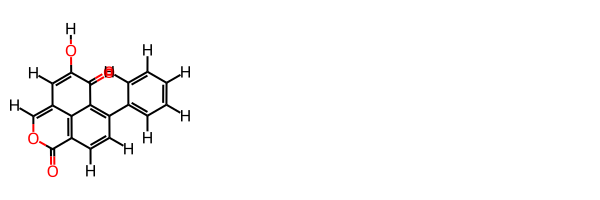

In [67]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([mol_test.iloc[2]])
